In [ ]:
from triqs_hubbardI import *
from triqs.gf import *
from triqs.operators import *
from ML_dmft.triqs_interface.triqs_interface import hyb
from triqs.plot.mpl_interface import oplot, plt
from math import pi
from numpy import cos
from triqs.lattice import BravaisLattice, BrillouinZone
from sklearn.metrics import mean_squared_error


: 

In [118]:
# params
beta=20.
n_l=64
n_iw=1024
n_tau=int(n_iw*10+1)
target_n_tau=256
basis='tau'
omp_threads=16
indices=[0]

E_p_=2.0
V_p_=1.5
E_p=[E_p_,E_p_,-E_p_,-E_p_]
V_p=[V_p_,V_p_,V_p_,V_p_]

Z_list=[]
U_list=[]

eps=0

solv_param = {"beta": beta,
                "n_l": n_l,
                "n_iw": n_iw,
                "n_tau": n_tau,
                "indices": indices,
                "basis": basis,
                "target_n_tau": target_n_tau,
                "omp_threads": omp_threads}

U=6

param={"E_p":E_p,
        "V_p":V_p,
        "eps":eps,
        "U":U}

U 6
t -6.0
error 0.0030699129607331542
error 3.586863388622914e-05
error 1.0999670508165384e-05
error 3.0648787462716132e-06
error 8.063677155787744e-07
error 2.0604187826620487e-07
error 5.1877593597959014e-08
error 1.2965784925415509e-08
error 3.2286176861562933e-09
error 8.024828076635981e-10


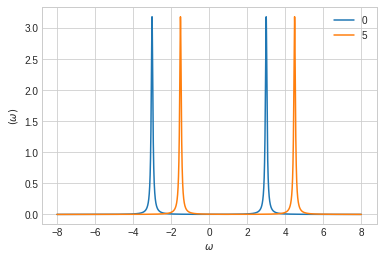

In [169]:
Delta_iw=GfImFreq(indices=indices,
                    beta=beta,
                    n_points=n_iw)

G_iw=GfImFreq(indices=indices,
                    beta=beta,
                    n_points=n_iw)
Sigma_iw=GfImFreq(indices=indices,
                    beta=beta,
                    n_points=n_iw)

G_l = GfLegendre(indices = indices, beta = beta,
                              n_points = n_l)    
G_l_last = GfLegendre(indices = indices, beta = beta,
                              n_points = n_l)    

G_loc_last = GfImFreq(indices=indices,
    beta=beta,
    n_points=n_iw)
                              
G_tau = GfImTime(indices=indices,
                beta=beta,
                n_points=n_tau)    

BL = BravaisLattice([(1, 0, 0), (0, 1, 0)]) # Two unit vectors in R3
BZ = BrillouinZone(BL) 
n_k=16
kmesh = MeshBrillouinZone(BZ, n_k=n_k)                       

def epsi(k):
    return -2 * t* (cos(k[0]) + cos(k[1]))
    

eps = -0.5*U # half filled
mu = -eps

t=eps-mu

print('U',U)
print('t',t)

S = Solver(beta = beta,
            n_iw=n_iw,
            gf_struct = [ ('up',[0]), ('down',[0]) ],
            idelta=0.5)

Delta_iw << hyb(param["E_p"], param["V_p"])


for loop in range(10):
    for name, g0 in S.G0_iw:
        g0 << inverse(iOmega_n + mu - Delta_iw)
        # g0 << gen_G_0(self.eps - self.U / 2., self.Delta_iw)

    S.solve(h_int = U * n('up',0) * n('down',0),
            calc_gw = True)

    G_iw << (S.G_iw['up']+S.G_iw['down'])/2.0
    Sigma_iw << (S.Sigma_iw['up']+S.G_iw['down'])/2.0
    G_tau << Fourier(G_iw)
    G_l << MatsubaraToLegendre(G_iw)

    G_loc = GfImFreq(indices=indices,
                    beta=beta,
                    n_points=n_iw)

    for k in kmesh:
        G_loc << G_loc + inverse(iOmega_n+mu-epsi(k)-Sigma_iw)
    G_loc << G_loc (n_k**2)
    
    print("error", \
        # mean_squared_error(G_l.data[:,0,0].real,G_l_last.data[:,0,0].real)
        mean_squared_error(G_loc_last.data[:,0,0].real,G_loc.data[:,0,0].real)
        )
    G_loc_last =G_loc.copy()
    Delta_iw << iOmega_n + mu -Sigma_iw - inverse(G_loc)
    
    G_w=GfReFreq(indices=[0], window=(-8.0,8.0))
    G_w.set_from_pade(G_iw,100, 1/beta)
    if loop%5==0:
        oplot(-G_w.imag/pi,label='%d'%loop)

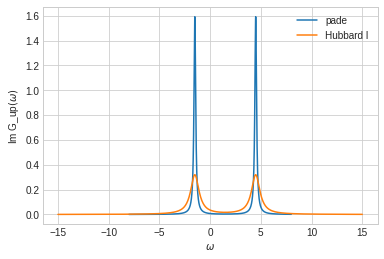

In [138]:
for name, g0 in S.G0_iw:
    g0 << inverse(iOmega_n + mu - Delta_iw)
    # g0 << gen_G_0(self.eps - self.U / 2., self.Delta_iw)

S.solve(h_int = U * n('up',0) * n('down',0),
        calc_gw = True)

G_iw << (S.G_iw['up']+S.G_iw['down'])/2.0
Sigma_iw << (S.Sigma_iw['up']+S.G_iw['down'])/2.0
G_tau << Fourier(G_iw)
G_l << MatsubaraToLegendre(G_iw)

G_w=GfReFreq(indices=[0], window=(-8.0,8.0))
G_w.set_from_pade(G_iw,10, 0.1)

S_G_w = G_w.copy()
S_G_w = (S.G_w['up']+S.G_w['down'])/2.0

oplot(-G_w.imag/pi,label='pade')
oplot(-S_G_w.imag/pi,label='Hubbard I')

In [151]:
Delta_iw << hyb(param["E_p"], param["V_p"])


Greens Function  with mesh Matsubara Freq Mesh of size 2048, Domain: Matsubara domain with beta = 20, statistic = Fermion, positive_only : 0 and target_shape (1, 1): 

In [163]:
Delta_tau=GfImTime(indices=indices,
                beta=beta,
                n_points=n_tau,name='Delta(tau)')    

Delta_tau << Fourier(Delta_iw)


Greens Function Delta(tau) with mesh Imaginary Time Mesh of size 10241, Domain: Matsubara domain with beta = 20, statistic = Fermion and target_shape (1, 1): 

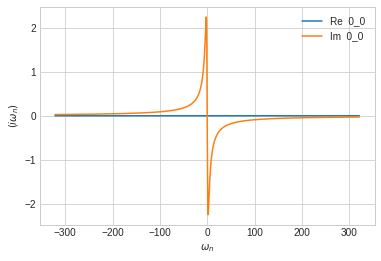

In [168]:
oplot(Delta_iw)

(0.0, 10.0)

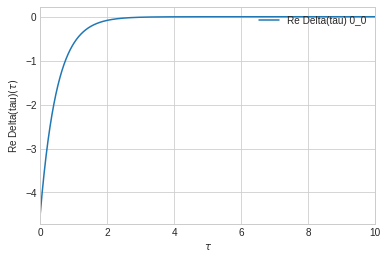

In [166]:
oplot(Delta_tau.real)
plt.xlim(0,10)

(-4.0, 4.0)

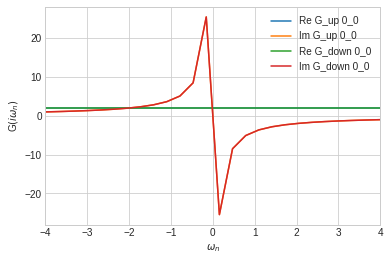

In [25]:
oplot(S.Sigma_iw)
plt.xlim(-4,4)